[WaveNet: A Generative Model for Raw Audio](https://arxiv.org/abs/1609.03499)


In [ ]:
import matplotlib.pyplot as plt 

import random
random.seed(42)

import torch
import torch.nn.functional as F
torch.manual_seed(42)

from model import NGram

import sys
sys.path.insert(0, "..")
from preprocessing import get_data, load_split_data

%matplotlib inline

### Load Data


In [ ]:
block_size = 8
words, stoi, itos = get_data()
Xtr, Ytr, Xdev, Ydev, Xte, Yte = load_split_data(words, stoi, block_size)

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


## Model


In [ ]:
vocab_size = 27
n_embd = 10
n_hidden = 200
max_steps = 200_000
batch_size = 32
lossi = []
ud = []

m = NGram(block_size, vocab_size, n_embd, n_hidden)

170870


## Train


3.2965750694274902
2.119041681289673
1.976542592048645
2.4047839641571045
1.9848244190216064
1.5458749532699585
1.7404934167861938
1.8551506996154785
1.735600233078003
2.2215631008148193
1.7932624816894531


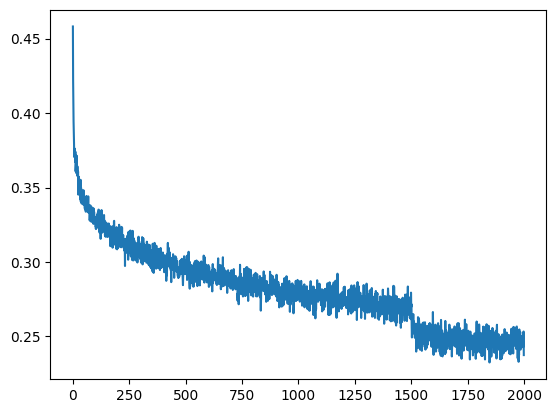

In [ ]:
m.train()

for i in range(max_steps):
    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))

    logits = m(Xtr[ix])
    loss = F.cross_entropy(logits, Ytr[ix])

    for layer in m.layers:
        layer.out.retain_grad()
    for p in m.parameters:
        p.grad = None
    loss.backward()

    if i % 20_000 == 0:
        print(loss.item())

    lr = 0.1 if i < 150_000 else 0.01
    for p in m.parameters:
        p.data += -lr * p.grad

    # track stats
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append(
            [((lr * p.grad).std() / p.data.std()).log10().item() for p in m.parameters]
        )

print(loss.item())
lossi_ = torch.tensor(lossi).view(-1, 100).mean(1)
plt.plot(range(len(lossi_)), lossi_)

In [ ]:
for l in m.layers:
    print("%20s : %s" % (l, tuple(l.out.shape)))

  Embedding (27, 10) : (32, 8, 10)
          Flatten () : (32, 4, 20)
    Linear (20, 200) : (32, 4, 200)
   BatchNorm1d (200) : (32, 4, 200)
             Tanh () : (32, 4, 200)
          Flatten () : (32, 2, 400)
   Linear (400, 200) : (32, 2, 200)
   BatchNorm1d (200) : (32, 2, 200)
             Tanh () : (32, 2, 200)
          Flatten () : (32, 400)
   Linear (400, 200) : (32, 200)
   BatchNorm1d (200) : (32, 200)
             Tanh () : (32, 200)
    Linear (200, 27) : (32, 27)


In [ ]:
m.eval()


@torch.no_grad()
def split_loss(split):
    x, y = {
        "train": (Xtr, Ytr),
        "val": (Xdev, Ydev),
        "test": (Xte, Yte),
    }[split]
    logits = m(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())


split_loss("train")
split_loss("val")

train 1.7329819202423096
val 1.9864205121994019


In [ ]:
for _ in range(20):

    out = []
    context = [0] * block_size
    while True:
        logits = m(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print("".join(itos[i] for i in out))

grayliee.
hellanee.
beymati.
bayleigh.
arizen.
copelt.
arma.
kynger.
ashdina.
sianny.
criti.
chade.
princesyn.
navin.
ethen.
zayior.
amyia.
oma.
dayvon.
arcelle.
